In [1]:
from fbprophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
INPUT_DIR = '../../input/m5-forecasting-accuracy'
sales=pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
calendar["date"] = pd.to_datetime(calendar["date"])

In [3]:
item_list = sales['item_id'].unique().tolist()
state_list = ['CA','TX','WI']
index_list = []
for state in state_list:
    for item in item_list:
        index_list.append(state+'_'+item)
df = pd.DataFrame(np.zeros([len(index_list), 1913]), columns=['d_'+str(i+1) for i in range(1913)], index = index_list)
for state in state_list:
    for item in item_list:
        df.iloc[df.index==state+'_'+item,0:] = sales[(sales['item_id']==item)&(sales['state_id']==state)].iloc[:,6:].sum().values

In [4]:
df.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
CA_HOBBIES_1_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,5.0,4.0,2.0,7.0,4.0,1.0,8.0,7.0
CA_HOBBIES_1_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,3.0,1.0
CA_HOBBIES_1_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,5.0,1.0,1.0,1.0,0.0,5.0,3.0,2.0
CA_HOBBIES_1_004,7.0,4.0,4.0,10.0,4.0,3.0,9.0,6.0,8.0,3.0,...,4.0,9.0,17.0,22.0,9.0,3.0,5.0,11.0,23.0,6.0
CA_HOBBIES_1_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,6.0,6.0,1.0,3.0,1.0,4.0,5.0,9.0,9.0


In [5]:
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2011-02-06','2012-02-05','2013-02-03','2014-02-02', '2015-02-01', '2016-02-07']),
  'lower_window': -3,
  'upper_window': 1,
})

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2016-01-09','2016-01-10','2016-01-16','2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': -1,
  'upper_window': 0,
})

NBA_days= []
for i,t in zip(calendar[calendar['event_name_1']=='NBAFinalsStart'].index.tolist(),calendar[calendar['event_name_1']=='NBAFinalsEnd'].index.tolist()):
    NBA_days.extend(pd.DatetimeIndex(calendar['date'].iloc[i:(t+1)]).tolist())
NBA_days = pd.DatetimeIndex(NBA_days)

NBA = pd.DataFrame({
  'holiday': 'NBA',
  'ds': NBA_days,
  'lower_window': -1,
  'upper_window': 0,
})

CA_snap = pd.DataFrame({
  'holiday': 'ca_snap',
  'ds': pd.DatetimeIndex(calendar[calendar['snap_CA']==1]['date'].values),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat([superbowls.loc[:,NBA.columns], playoffs.loc[:,NBA.columns],NBA.loc[:,NBA.columns],CA_snap.loc[:,NBA.columns]],axis=0)

In [6]:
NBA.columns

Index(['holiday', 'ds', 'lower_window', 'upper_window'], dtype='object')

In [46]:
sample_df = pd.concat([calendar.loc[:1912,['date']], pd.DataFrame(df.T['CA_HOBBIES_1_001'].reset_index(drop=True))],axis=1)
sample_df = sample_df.rename({"date": "ds", "CA_HOBBIES_1_001": "y"}, axis=1)

In [52]:
def cut_outrange(in_df):
    out_df = in_df.copy()
    p0 =  out_df['y'].min()
    p95 = out_df['y'].quantile(0.95)
    out_df['y'] = out_df['y'].clip(p0,p95)
    return out_df

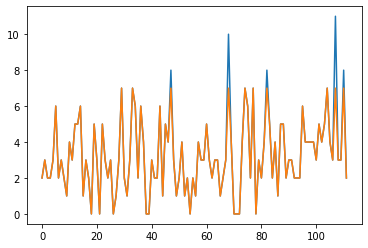

In [62]:
TRAIN_DAYS = 28*4
train = sample_df.iloc[-1*(TRAIN_DAYS+28):-28]
aa=cut_outrange(train)
plt.plot(train['y'].values)
plt.plot(aa['y'].values)
plt.show()

In [56]:
TRAIN_DAYS = 28*4
GROWTH = 1.01

model=Prophet(growth='logistic', holidays=holidays, seasonality_mode='multiplicative', weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=True)
model.add_country_holidays(country_name='US')
train = cut_outrange(sample_df.iloc[-1*(TRAIN_DAYS+28):-28])
train['cap'] = train['y'].max()*GROWTH
model.fit(train)

future_df = model.make_future_dataframe(28)
future_df['cap'] = train['y'].max()*GROWTH
forecast_df = model.predict(future_df)

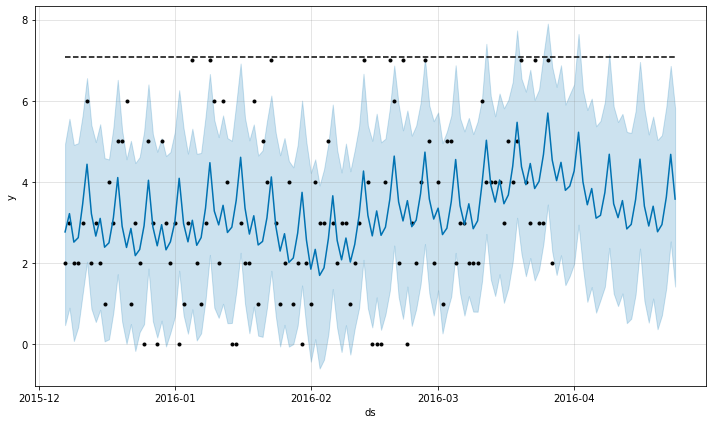

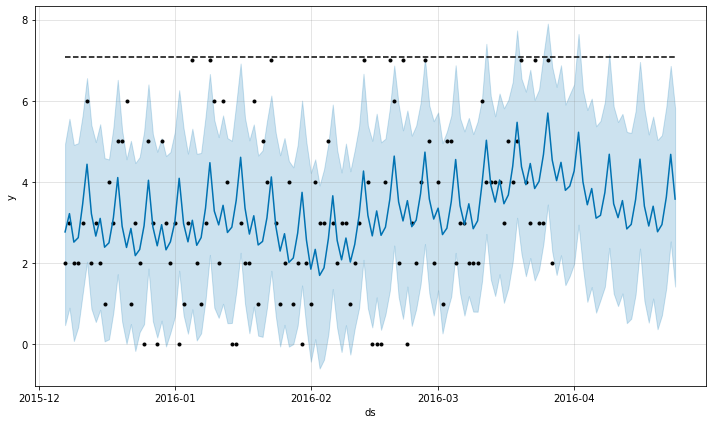

In [57]:
model.plot(forecast_df)

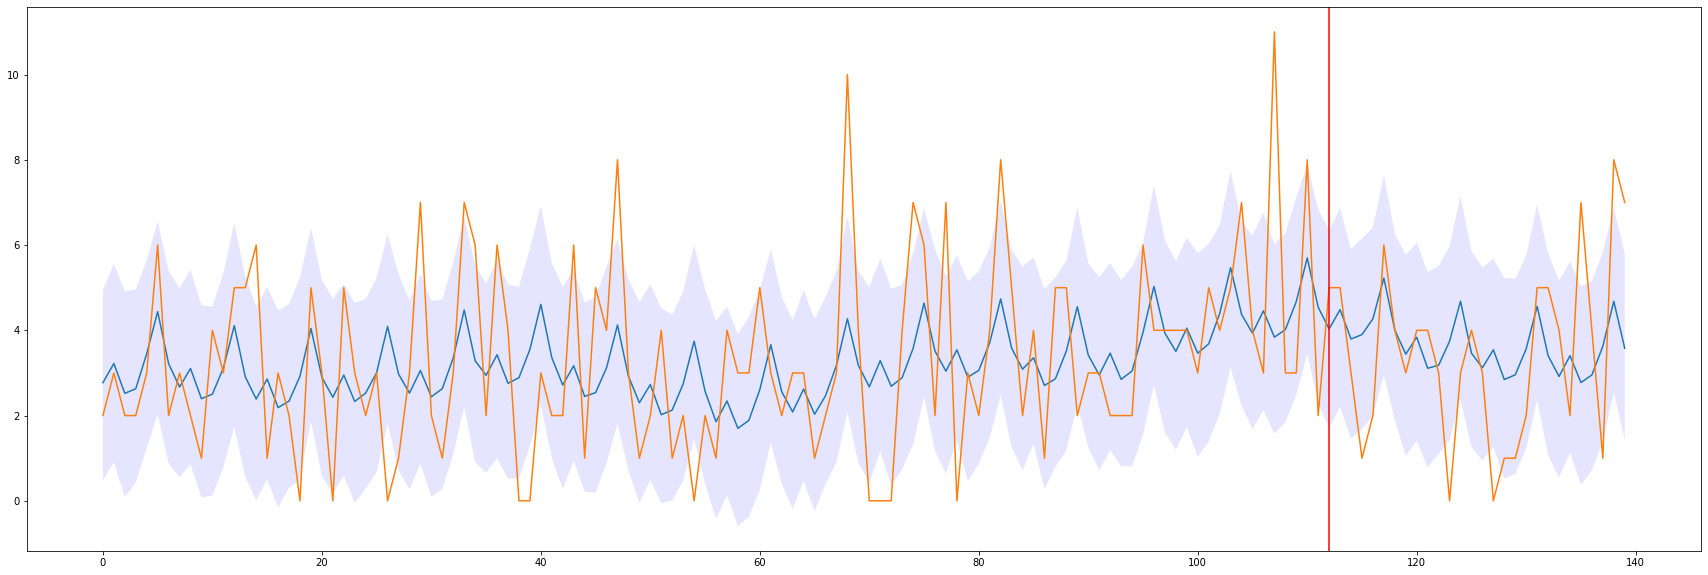

In [58]:
plt.figure(figsize=(30, 10))
plt.plot(forecast_df['yhat'][-1*(TRAIN_DAYS+28):].values)
plt.fill_between(np.arange(TRAIN_DAYS+28),forecast_df['yhat_upper'][-1*(TRAIN_DAYS+28):].values,forecast_df['yhat_lower'][-1*(TRAIN_DAYS+28):].values,facecolor='b',alpha=0.1)
plt.plot(sample_df['y'].iloc[-1*(TRAIN_DAYS+28):].values)
plt.axvline(x=TRAIN_DAYS, ymin=0, ymax=10,color='red')
plt.show()

In [82]:
def predict_prophet(df_name):
    sample_df = pd.concat([calendar.loc[:1912,['date']], pd.DataFrame(df.T[df_name].reset_index(drop=True))],axis=1)
    sample_df = sample_df.rename({"date": "ds", df_name: "y"}, axis=1)
    TRAIN_DAYS = 365*2
    GROWTH = 1.01

    model=Prophet(growth='logistic', holidays=holidays, seasonality_mode='multiplicative', weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=False)
    model.add_country_holidays(country_name='US') 
    train = cut_outrange(sample_df.iloc[-1*(TRAIN_DAYS+28):-28])
    train['cap'] = train['y'].max()*GROWTH
    model.fit(train)

    future_df = model.make_future_dataframe(28)
    future_df['cap'] = train['y'].max()*GROWTH
    forecast_df = model.predict(future_df)
    
    model.plot(forecast_df)
    
    plt.figure(figsize=(30, 10))
    plt.plot(forecast_df['yhat'][-1*(TRAIN_DAYS+28):].values)
    plt.fill_between(np.arange(TRAIN_DAYS+28),forecast_df['yhat_upper'][-1*(TRAIN_DAYS+28):].values,forecast_df['yhat_lower'][-1*(TRAIN_DAYS+28):].values,facecolor='b',alpha=0.1)
    plt.plot(sample_df['y'].iloc[-1*(TRAIN_DAYS+28):].values)
    plt.axvline(x=TRAIN_DAYS, ymin=0, ymax=10,color='red')
    plt.show()

In [83]:
df.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
CA_HOBBIES_1_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,5.0,4.0,2.0,7.0,4.0,1.0,8.0,7.0
CA_HOBBIES_1_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,3.0,1.0
CA_HOBBIES_1_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,5.0,1.0,1.0,1.0,0.0,5.0,3.0,2.0
CA_HOBBIES_1_004,7.0,4.0,4.0,10.0,4.0,3.0,9.0,6.0,8.0,3.0,...,4.0,9.0,17.0,22.0,9.0,3.0,5.0,11.0,23.0,6.0
CA_HOBBIES_1_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,6.0,6.0,1.0,3.0,1.0,4.0,5.0,9.0,9.0


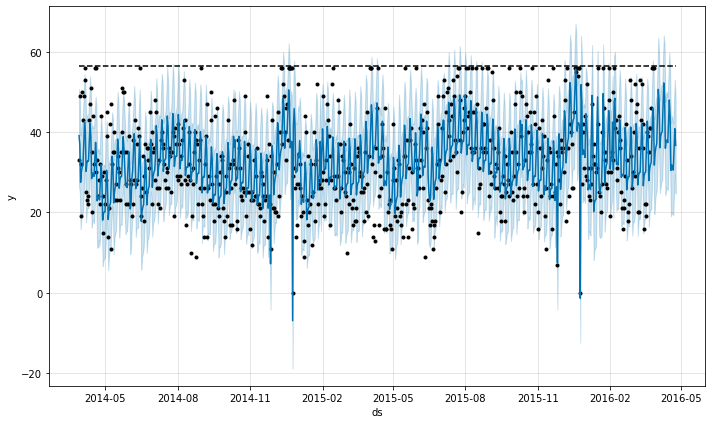

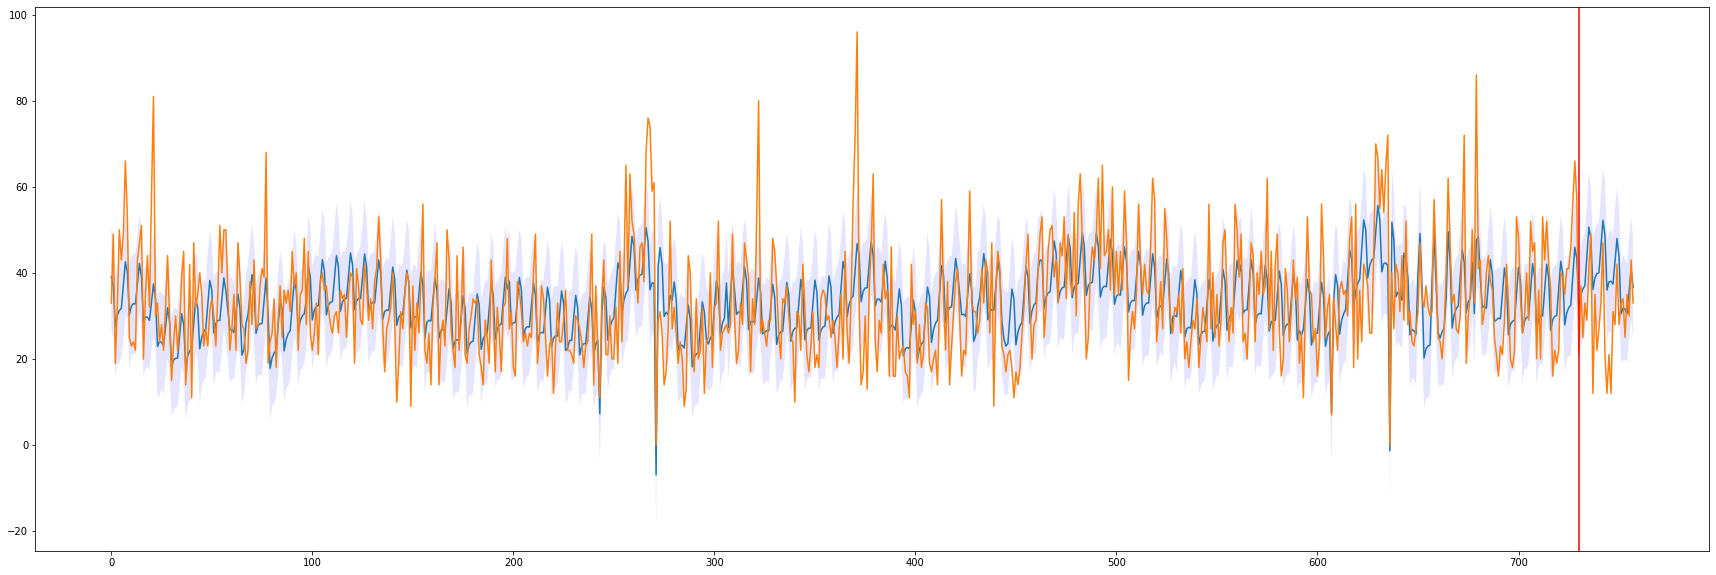

In [89]:
predict_prophet('CA_FOODS_1_099')

In [80]:
calendar.tail(50)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1919,2016-05-01,11614,Sunday,2,5,2016,d_1920,OrthodoxEaster,Religious,NaN,NaN,1,1,0
1920,2016-05-02,11614,Monday,3,5,2016,d_1921,NaN,NaN,NaN,NaN,1,0,1
1921,2016-05-03,11614,Tuesday,4,5,2016,d_1922,NaN,NaN,NaN,NaN,1,1,1
1922,2016-05-04,11614,Wednesday,5,5,2016,d_1923,NaN,NaN,NaN,NaN,1,0,0
1923,2016-05-05,11614,Thursday,6,5,2016,d_1924,Cinco De Mayo,Cultural,NaN,NaN,1,1,1
1924,2016-05-06,11614,Friday,7,5,2016,d_1925,NaN,NaN,NaN,NaN,1,1,1
1925,2016-05-07,11615,Saturday,1,5,2016,d_1926,NaN,NaN,NaN,NaN,1,1,0
1926,2016-05-08,11615,Sunday,2,5,2016,d_1927,Mother's day,Cultural,NaN,NaN,1,0,1
1927,2016-05-09,11615,Monday,3,5,2016,d_1928,NaN,NaN,NaN,NaN,1,1,1
1928,2016-05-10,11615,Tuesday,4,5,2016,d_1929,NaN,NaN,NaN,NaN,1,0,0
